# <p style="font-family:Roboto Slab; font-weight:bold; letter-spacing: 2px; color:#8A2BE2; font-size:200%; text-align:left; padding: 0px; display: inline-block; border-bottom: 4px solid #4B0082;"> Training </p>

In [1]:
import numpy as np 
import pandas as pd 
import os
import gc
import sys
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from functools import partial


from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier


from sklearn.metrics import f1_score
!pip install cmaes
!pip install optuna
import optuna
from tqdm import tqdm
from copy import deepcopy

from sklearn.svm import SVC

import warnings
warnings.filterwarnings("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.5/64.5 kB 3.0 MB/s eta 0:00:00


## <p style="font-family:Roboto Slab; font-weight:bold; letter-spacing: 2px; color:#8A2BE2; font-size:150%; text-align:left;padding: 0px; display: inline-block; border-bottom: 4px solid #4B0082"> Configuration </p>

In [2]:
class CFG:
    BASE_PATH = '/kaggle/input/playground-series-s3e22'
    SAVE_PATH = '/kaggle/working'
    TARGET = 'outcome'
    
    TRAIN = True
    n_splits = 5
    test_size = 0.3
    random_state = 42
    verbose = False

    n_classes = 3

    nan_cols = ['temp_of_extremities', 'peripheral_pulse',
                 'capillary_refill_time','pain', 'peristalsis','abdominal_distention',
                 'nasogastric_tube','nasogastric_reflux','rectal_exam_feces',
                 'abdomen','abdomo_appearance']
    
    binary_col = ["surgery", "age", "surgical_lesion", "cp_data"]
    
    ohe_cols = ["mucous_membrane"]

    # base model = 
    decision_function_shape = 'ovo'

    n_estimators = 10000
    device = 'cpu'

    # optium 
    n_trials = 10000
    early_stopping_rounds = 100

    class_weights_dict = {0:0.7, 1:1, 2:0.45}

    debug = False

    def update_debug(self):
        if self.debug:
            self.n_trials = 10
            self.n_estimators = 5
            self.n_splits = 2
            self.early_stopping_rounds = 5
        
cfg = CFG()

if cfg.debug:
    cfg.update_debug()

In [3]:
def read_data(file, cfg=cfg):
    try:
        return pd.read_csv(f'{cfg.BASE_PATH}/{file}.csv')
    except:
        print(f"{cfg.BASE_PATH}/{file}.csv not found, Enter valid one - [train/test]")

In [4]:
def score(y_true, y_pred, cfg=cfg):
    return f1_score(y_true, y_pred, average="micro")

def save_file(file_name, data, cfg=cfg):
    with open(f"{cfg.SAVE_PATH}/{file_name}", 'wb') as f:
        pickle.dump(data, f)

def load_file(file_name, cfg=cfg):
    with open(f"{cfg.SAVE_PATH}/{file_name}", 'rb') as f:
        return pickle.load(f)

## <p style="font-family:Roboto Slab; font-weight:bold; letter-spacing: 2px; color:#8A2BE2; font-size:150%; text-align:left;padding: 0px; display: inline-block; border-bottom: 4px solid #4B0082"> Load Data </p>

In [5]:
train = read_data('train')
test = read_data('test')
id_ = test.id

train.drop(['id', 'lesion_3'], axis=1, inplace=True)
test.drop(['id', 'lesion_3'], axis=1, inplace=True)

train.drop_duplicates(inplace=True)

In [6]:
X = train.drop('outcome', axis=1)
y = train['outcome'].map({'died':0, 'lived':1, 'euthanized':2})

## <p style="font-family:Roboto Slab; font-weight:bold; letter-spacing: 2px; color:#8A2BE2; font-size:150%; text-align:left;padding: 0px; display: inline-block; border-bottom: 4px solid #4B0082"> Preprocessing </p>

In [7]:
# taken from https://www.kaggle.com/code/yaaangzhou/pg-s3-e22-very-simple-approach
def preprocessing(df, le_cols, ohe_cols, cfg=cfg):
    
    # Label Encoding for binary cols
    le = LabelEncoder()    
    for col in le_cols:
        df[col] = le.fit_transform(df[col])
    
    # OneHot Encoding for category cols
    df = pd.get_dummies(df, columns=ohe_cols, dtype=int)
    
    df["pain"] = df["pain"].replace('slight', 'moderate')
    df["peristalsis"] = df["peristalsis"].replace('distend_small', 'normal')
    df["rectal_exam_feces"] = df["rectal_exam_feces"].replace('serosanguious', 'absent')
    df["nasogastric_reflux"] = df["nasogastric_reflux"].replace('slight', 'none')
        
    df["temp_of_extremities"] = df["temp_of_extremities"].fillna("normal").map({'cold': 0, 'cool': 1, 'normal': 2, 'warm': 3})
    df["peripheral_pulse"] = df["peripheral_pulse"].fillna("normal").map({'absent': 0, 'reduced': 1, 'normal': 2, 'increased': 3})
    df["capillary_refill_time"] = df["capillary_refill_time"].fillna("3").map({'less_3_sec': 0, '3': 1, 'more_3_sec': 2})
    df["pain"] = df["pain"].fillna("depressed").map({'alert': 0, 'depressed': 1, 'moderate': 2, 'mild_pain': 3, 'severe_pain': 4, 'extreme_pain': 5})
    df["peristalsis"] = df["peristalsis"].fillna("hypomotile").map({'hypermotile': 0, 'normal': 1, 'hypomotile': 2, 'absent': 3})
    df["abdominal_distention"] = df["abdominal_distention"].fillna("none").map({'none': 0, 'slight': 1, 'moderate': 2, 'severe': 3})
    df["nasogastric_tube"] = df["nasogastric_tube"].fillna("none").map({'none': 0, 'slight': 1, 'significant': 2})
    df["nasogastric_reflux"] = df["nasogastric_reflux"].fillna("none").map({'less_1_liter': 0, 'none': 1, 'more_1_liter': 2})
    df["rectal_exam_feces"] = df["rectal_exam_feces"].fillna("absent").map({'absent': 0, 'decreased': 1, 'normal': 2, 'increased': 3})
    df["abdomen"] = df["abdomen"].fillna("distend_small").map({'normal': 0, 'other': 1, 'firm': 2,'distend_small': 3, 'distend_large': 4})
    df["abdomo_appearance"] = df["abdomo_appearance"].fillna("serosanguious").map({'clear': 0, 'cloudy': 1, 'serosanguious': 2})
    
    # All nan_cols are object so using mode
    for feature in cfg.nan_cols:
        df[feature].fillna(df[feature].mode()[0], inplace=True)
     
    return df  

X = preprocessing(X, le_cols=cfg.binary_col, ohe_cols=cfg.ohe_cols)

In [8]:
# idea taken from https://www.kaggle.com/code/arunklenin/challenging-data-points-cosine-similarity#7.-Balance-Classes
class Splitter:
    def __init__(self, cfg=cfg, kfold=True):
        super().__init__()
        self.test_size = cfg.test_size
        self.kfold = kfold
        self.n_splits = cfg.n_splits

    def split_data(self, X, y):
        if self.kfold:
            kf = KFold(n_splits=self.n_splits, random_state=cfg.random_state, shuffle=True)
            for train_index, val_index in kf.split(X, y):
                X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                y_train, y_val = y.iloc[train_index], y.iloc[val_index]
                yield X_train, X_val, y_train, y_val
        else:
            X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y)
            yield X_train, X_val, y_train, y_val


class Classifier:
    def __init__(self, model_type='base', cfg=cfg):
        super().__init__()
        self.model_type = model_type 
        self.models = self.prepare_model()
        self.len_models = len(self.models)


    def prepare_model(self):
        if self.model_type == 'base':
            return [SVC(decision_function_shape=cfg.decision_function_shape)]

        elif self.model_type == 'main':
            xgb_params = {
                    'n_estimators': cfg.n_estimators,
                    'learning_rate': 0.05,
                    'max_depth': 4,
                    'subsample': 0.8,
                    'colsample_bytree': 0.1,
                    'n_jobs': -1,
                    'eval_metric': 'merror',
                    'objective': 'multi:softmax',
                    'tree_method': 'hist',
                    'verbosity': 0,
                    'random_state': cfg.random_state,
                    'class_weight':cfg.class_weights_dict,
                }
            if cfg.device == 'gpu':
                xgb_params['tree_method'] = 'gpu_hist'
                xgb_params['predictor'] = 'gpu_predictor'
                    
            xgb_params2=xgb_params.copy() 
            xgb_params2['subsample']= 0.3
            xgb_params2['max_depth']=8
            xgb_params2['learning_rate']=0.005
            xgb_params2['colsample_bytree']=0.9
    
            
            lgb_params = {
                'n_estimators': cfg.n_estimators,
                'max_depth': 8,
                'learning_rate': 0.02,
                'subsample': 0.20,
                'colsample_bytree': 0.56,
                'reg_alpha': 0.25,
                'reg_lambda': 5e-08,
                'objective': 'multiclass',
                'metric': 'multi_logloss',
                'boosting_type': 'gbdt',
                'device': cfg.device,
                'random_state': cfg.random_state,
                'class_weight':cfg.class_weights_dict,
                'verbosity': -1
            }
            lgb_params2 = {
                'n_estimators': cfg.n_estimators,
                'max_depth': 5,
                'learning_rate': 0.05,
                'subsample': 0.20,
                'colsample_bytree': 0.56,
                'reg_alpha': 0.25,
                'reg_lambda': 5e-08,
                'objective': 'multiclass',
                'metric': 'multi_logloss',
                'boosting_type': 'gbdt',
                'device': cfg.device,
                'random_state': cfg.random_state,
                'class_weight':cfg.class_weights_dict,
                'verbosity': -1
            }
            lgb_params3=lgb_params.copy()  
            lgb_params3['subsample']=0.9
            lgb_params3['reg_lambda']=0.3461495211744402
            lgb_params3['reg_alpha']=0.3095626288582237
            lgb_params3['max_depth']=9
            lgb_params3['learning_rate']=0.007
            lgb_params3['colsample_bytree']=0.5
    
                    
            cb_params = {
                'iterations': cfg.n_estimators,
                'depth': 6,
                'learning_rate': 0.05,
                'l2_leaf_reg': 0.7,
                'random_strength': 0.2,
                'max_bin': 200,
                'od_wait': 65,
                'one_hot_max_size': 70,
                'grow_policy': 'Depthwise',
                'bootstrap_type': 'Bayesian',
                'od_type': 'Iter',
                'eval_metric': 'TotalF1',
                'loss_function': 'MultiClass',
                'task_type': cfg.device.upper(),
                'random_state': cfg.random_state,
            }
            cb_sym_params = cb_params.copy()
            cb_sym_params['grow_policy'] = 'SymmetricTree'
            cb_loss_params = cb_params.copy()
            cb_loss_params['grow_policy'] = 'Lossguide'
            
            cb_params2=  cb_params.copy()
            cb_params2['learning_rate']=0.01
            cb_params2['depth']=8
            
            cb_params3={
                'iterations': cfg.n_estimators,
                'random_strength': 0.1, 
                'one_hot_max_size': 70, 'max_bin': 100, 
                'learning_rate': 0.008, 
                'l2_leaf_reg': 0.3, 
                'grow_policy': 'Depthwise', 
                'depth': 9, 
                'max_bin': 200,
                'od_wait': 65,
                'bootstrap_type': 'Bayesian',
                'od_type': 'Iter',
                'eval_metric': 'TotalF1',
                'loss_function': 'MultiClass',
                'task_type': cfg.device.upper(),
                'random_state': cfg.random_state,
            }
            models = {
                'svc': SVC(gamma="auto", probability=True, random_state=cfg.random_state),
                'xgb': xgb.XGBClassifier(**xgb_params),
                'xgb2': xgb.XGBClassifier(**xgb_params2),
                'lgb': lgb.LGBMClassifier(**lgb_params),
                'lgb2': lgb.LGBMClassifier(**lgb_params2),
                'lgb3': lgb.LGBMClassifier(**lgb_params3),
                'cat': CatBoostClassifier(**cb_params),
                "cat_sym": CatBoostClassifier(**cb_sym_params),
                "cat_loss": CatBoostClassifier(**cb_loss_params),
                'cat2': CatBoostClassifier(**cb_params2),
                'rf': RandomForestClassifier(n_estimators=1000, random_state=cfg.random_state),
                'hist_gbm' : HistGradientBoostingClassifier (max_iter=300, learning_rate=0.001,  max_leaf_nodes=80,
                                                             max_depth=6,class_weight=cfg.class_weights_dict, random_state=cfg.random_state)
            }
            return models

        else:
            print(f"No such choice {self.model_type} --- valid are [main/base]")

In [9]:
class OptunaWeights:
    def __init__(self, cfg=cfg):
        self.study = None
        self.weights = None
        self.random_state = cfg.random_state
        self.n_trials = cfg.n_trials

    def objective(self, trial, y_true, y_preds):
        # Define the weights for the predictions from each model
        weights = [trial.suggest_float(f"weight{n}", -1, 2) for n in range(len(y_preds))]

        # Calculate the weighted prediction
        weighted_pred = np.average(np.array(y_preds), axis=0, weights=weights)
        
        weighted_pred_labels = np.argmax(weighted_pred, axis=1)
    
        return score(y_true, weighted_pred_labels)

    def fit(self, y_true, y_preds):
        optuna.logging.set_verbosity(optuna.logging.ERROR)
        sampler = optuna.samplers.CmaEsSampler(seed=self.random_state)
        pruner = optuna.pruners.HyperbandPruner()
        self.study = optuna.create_study(sampler=sampler, pruner=pruner, study_name="OptunaWeights", direction='maximize')
        objective_partial = partial(self.objective, y_true=y_true, y_preds=y_preds)
        self.study.optimize(objective_partial, n_trials=self.n_trials)
        self.weights = [self.study.best_params[f"weight{n}"] for n in range(len(y_preds))]

    def predict(self, y_preds):
        assert self.weights is not None, 'OptunaWeights error, must be fitted before predict'
        weighted_pred = np.average(np.array(y_preds), axis=0, weights=self.weights)
        return weighted_pred

    def fit_predict(self, y_true, y_preds):
        self.fit(y_true, y_preds)
        return self.predict(y_preds)
    
    def get_weights(self):
        return self.weights

## <p style="font-family:Roboto Slab; font-weight:bold; letter-spacing: 2px; color:#8A2BE2; font-size:150%; text-align:left; padding: 0px; display: inline-block; border-bottom: 4px solid #4B0082;"> Base Model </p>

In [10]:
c = Classifier('base')
svc = c.prepare_model()[0]

base_splitter = Splitter(kfold=False)
X_train, X_val, y_train, y_val = train_test_split(X, y)

svc.fit(X_train, y_train)

print(f"\033[94m {score(y_val, svc.predict(X_val))}\033[00m")


del base_splitter, X_train, X_val, y_train, y_val, svc, c
gc.collect();

 0.44660194174757284


## <p style="font-family:Roboto Slab; font-weight:bold; letter-spacing: 2px; color:#8A2BE2; font-size:150%; text-align:left; padding: 0px; display: inline-block; border-bottom: 4px solid #4B0082;"> Train Actual Model </p>

In [11]:
def train_find_weights(X, y, cfg=cfg):
    
    ensemble_score = []
    ensemble_f1_score = []
    weights = []
    trained_models = {'svc': [],
    'xgb': [], 'xgb2': [],
    'lgb': [], 'lgb2': [], 'lgb3': [],
    'cat': [], 'cat_sym': [], 'cat_loss': [], 'cat2': [],
    'rf': [],
    'hist_gbm': []}
    
    splitter = Splitter(cfg=cfg)
    for i, (X_train, X_val, y_train, y_val) in enumerate(splitter.split_data(X, y)):
        
        classifier = Classifier('main', cfg)
        models = classifier.models

        oof_preds = []
        test_preds = []

        max_score = -1
        mname = ''

        print(f"================ Fold {i + 1} ================")

        text = ''
        pbar = tqdm(models.items(), total=len(models.items()), file=sys.stdout, colour='GREEN', unit='it')
        for name, model in pbar:
            if ('xgb' in name) or ('cat' in name)  :
                model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=cfg.early_stopping_rounds, verbose=cfg.verbose)

            elif ('lgb' in name):
                model.fit(X_train, y_train, eval_set=[(X_val, y_val)])
            else:
                model.fit(X_train, y_train)
                
            trained_models[f'{name}'].append(deepcopy(model))
            
            y_val_pred = model.predict_proba(X_val)
    
            y_val_pred_labels = np.argmax(y_val_pred, axis=1)
            f1_micro_score = score(y_val, y_val_pred_labels)
            oof_preds.append(y_val_pred)
            
            text += f'{name} ----- F1 Micro Score: {f1_micro_score:.5f}\n'
            
            ord_dict = {
                "Current": name,
                "Best Model": mname,
                "Best Score": round(max_score, 2)
            }

            pbar.set_postfix(ord_dict, refresh=True)
            if f1_micro_score > max_score:
                max_score = f1_micro_score
                mname = name
                
        optweights = OptunaWeights(cfg)
        y_val_pred = optweights.fit_predict(y_val, oof_preds)
        
        y_val_pred_labels = np.argmax(y_val_pred, axis=1)
        f1_micro_score = score(y_val, y_val_pred_labels)

        text += f'Ensemble Score ----- F1 Micro Score: {f1_micro_score:.5f}'
        print(text)

        ensemble_score.append(score)
        ensemble_f1_score.append(f1_micro_score)
        weights.append(optweights.weights)  

    save_file('trained_models.pkl', trained_models)
    save_file('ensemble_score.pkl', ensemble_score)
    save_file('weights.pkl', weights)
    save_file('ensemble_f1_score.pkl', ensemble_f1_score)
    
    return trained_models, weights, ensemble_score, ensemble_f1_score

# <p style="font-family:Roboto Slab; font-weight:bold; letter-spacing: 2px; color:#8A2BE2; font-size:200%; text-align:left; padding: 0px; display: inline-block; border-bottom: 4px solid #4B0082;"> Inference </p>

In [12]:
def predict(test, trained_models=None, weights=None, cfg=cfg):
    if trained_models == None:
        trained_models = load_file('trained_models.pkl')

    if weights == None:
        weights = np.array(load_file('weights.pkl'))

    test = preprocessing(test, le_cols=cfg.binary_col, ohe_cols=cfg.ohe_cols)

    models = list(trained_models.keys())
    n_folds = len(weights)
    n_models = len(models)

    # store the fold result
    test_preds = np.zeros((test.shape[0], cfg.n_classes))

    assert weights.shape == (n_folds, n_models), "Weights shape mismatch!"
    
    for i, w in enumerate(weights):
        print(f"================ Fold {i + 1} ================")
        pbar = tqdm(enumerate(models), total=n_models, file=sys.stdout, colour='GREEN', unit='model', desc="Predicting")

        # store the model result here
        fold_weights = weights[i]
        ttest = np.zeros_like(test_preds)
        
        for j, m in pbar:
            model_pred = trained_models[m][i].predict_proba(test)
            ttest += fold_weights[j] * model_pred

        # only one move forward
        test_preds += ttest / np.sum(fold_weights)

    test_preds /= n_folds


    return np.argmax(test_preds, axis=1)

In [13]:
def create_submission(id_, preds):
    output = pd.DataFrame()

    preds = pd.Series(preds).map({0: 'died', 1:'lived', 2:'euthanized'})
    output["id"] = id_
    output['outcome'] = preds

    counts = preds.value_counts()

    output.to_csv("submission.csv", index=False)

    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90, colors=['#9370DB', '#9400D3', '#A020F0'])
    plt.title("Test Predictions")
    plt.tight_layout()
    plt.show()

========= Training =========
================ Fold 1 ================
100%|██████████| 12/12 [00:34<00:00,  2.88s/it, Current=hist_gbm, Best Model=xgb, Best Score=0.75]
svc ----- F1 Micro Score: 0.53846
xgb ----- F1 Micro Score: 0.74899
xgb2 ----- F1 Micro Score: 0.72470
lgb ----- F1 Micro Score: 0.69231
lgb2 ----- F1 Micro Score: 0.68421
lgb3 ----- F1 Micro Score: 0.69231
cat ----- F1 Micro Score: 0.72065
cat_sym ----- F1 Micro Score: 0.74089
cat_loss ----- F1 Micro Score: 0.73684
cat2 ----- F1 Micro Score: 0.72065
rf ----- F1 Micro Score: 0.71255
hist_gbm ----- F1 Micro Score: 0.56680
Ensemble Score ----- F1 Micro Score: 0.76923
================ Fold 2 ================
100%|██████████| 12/12 [00:35<00:00,  2.97s/it, Current=hist_gbm, Best Model=xgb, Best Score=0.78]
svc ----- F1 Micro Score: 0.46964
xgb ----- F1 Micro Score: 0.78138
xgb2 ----- F1 Micro Score: 0.74089
lgb ----- F1 Micro Score: 0.77328
lgb2 ----- F1 Micro Score: 0.75304
lgb3 ----- F1 Micro Score: 0.77733
cat ----- F1 M

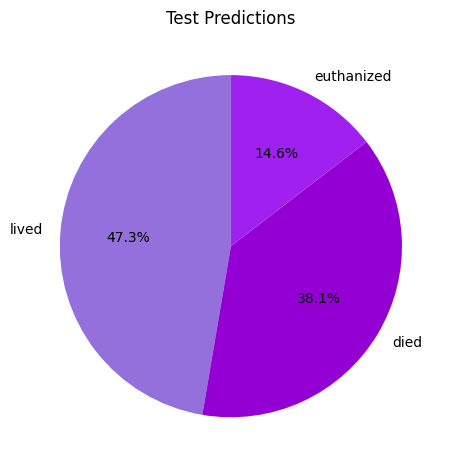

In [14]:
if __name__ == "__main__":
    # preproccss the train 

    if cfg.TRAIN:
        print("========= Training =========")
        train_find_weights(X, y)


    # predict test


    print("\n"* 4)
    print("========= Predicting =========")
    predictions = predict(test)

    print("\n"* 4)
    print("========= Creating Submission =========")
    create_submission(id_, predictions)